Load in our precomputed DINOV2 feature maps for CIRFAR10

In [5]:
import torch
dino_cifar10 = torch.load("dino_cifar10.pt")
print(list(dino_cifar10.shape))

dino_cifar10 = dino_cifar10.reshape(50000,257*768)

[50000, 257, 768]


Load our pretrained (or more accurately, prefinetuned) Stable Diffusion 1.5 Model

In [6]:
from diffusers import DiffusionPipeline

import os
p = ".\\FineTuned-SD1-cifar10"
print(os.path.isdir(p))

pipe = DiffusionPipeline.from_pretrained(p)
pipe.to("cuda")
print("") #Stop ipynb dumping rubbish after this block

True


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Generate a sample image from our Diffusion Model

100%|██████████| 50/50 [00:02<00:00, 18.36it/s]


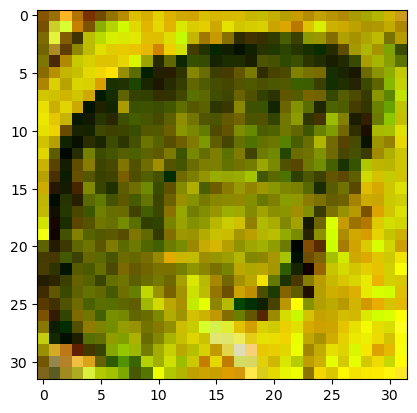

In [7]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

image = pipe(
    height=32, #Why are these not in the docssssss
    width=32,
    prompt="frog",
).images[0]

plt.imshow(image)

Now generate attributions using cosine similarity on the DINOV2 feature maps

In [11]:
from transformers import AutoImageProcessor, Dinov2Model

image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")

model = Dinov2Model.from_pretrained("facebook/dinov2-base")

input_image = image_processor(image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**input_image)

last_hidden_state = outputs.last_hidden_state

last_hidden_state = last_hidden_state.reshape(1,257*768)

print(last_hidden_state.shape)
print(dino_cifar10.shape)

cosine_similarity = torch.nn.CosineSimilarity(dim=1)

c = torch.zeros(1,50000)

set_size = 1000
dataset_size = 50000

for i in range(0,dataset_size//set_size):
    a=i*set_size
    b=(i+1)*set_size

    c[0,a:b] = cosine_similarity(last_hidden_state,dino_cifar10[a:b])

print(c.shape)
print(c)
print(torch.argmax(c))

torch.Size([1, 197376])
torch.Size([50000, 197376])
torch.Size([1, 50000])
tensor([[0.0455, 0.1260, 0.0952,  ..., 0.0534, 0.0894, 0.0733]])
tensor(9205)


In [13]:
del dino_cifar10

from datasets import load_dataset

#https://huggingface.co/datasets/

dataset_name = "uoft-cs/cifar10"
dataset = load_dataset(dataset_name, split="train")

dataset = dataset.rename_column("img", "image")

tensor([ 9205, 33561, 10146, 19216,  8298, 26539, 42729,  9963, 10639, 46721])


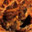

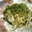

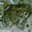

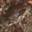

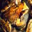

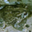

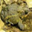

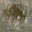

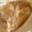

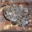

In [14]:
best_matches = torch.flatten(torch.topk(c,10).indices)
print(best_matches)

for i in range(10):
    display(dataset["image"][best_matches[i]])